In [1]:
import os
import pickle

import numpy as np
import pandas as pd

import operator

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from scipy.stats import binom
from scipy.stats import entropy
from scipy.stats import pearsonr

import zarr

from utils.utility_functions import (transposeZarr, log_transform, clip_outlier_pixels)

In [2]:
# Paths and input
out = os.path.join(os.getcwd(), 'output/VAE20_entropy_by_Leiden')
if not os.path.exists(out):
    os.makedirs(out)

# Read single-cell sample for VAE analysis
main = pd.read_csv(os.path.join(os.getcwd(), 'input/main.csv'))

# Optional: filter VAE20 clusters to analyze according to their abundance
filt = main.groupby('VAE20').size()
filt = filt.index[filt > 0]
filt = filt.tolist()

df = main[main['VAE20'].isin(filt)]
df = df[df['VAE20'] != -1]

count_headers = [f'L{i}' for i in sorted(df['Leiden'].unique())]

In [3]:
if not os.path.exists(os.path.join(out, 'counts_minus_ref.csv')):

    counts = pd.DataFrame(columns=['VAE20', 'Leiden'] + count_headers)

    for vae_cluster, group in df.groupby('VAE20'):
        print(vae_cluster)
        for i in group.iterrows():
            dta = pd.DataFrame(columns=['VAE20', 'Leiden'] + count_headers)
            dta.loc[0, 'VAE20'] = vae_cluster
            dta.loc[0, 'Leiden'] = int(i[1]['Leiden'])
            dta.loc[0, count_headers] = 0

            # Isolate cells within 30x30 pixel area (20um2)
            x = i[1]['X_centroid']
            y = i[1]['Y_centroid']
            patch = (
                df[(df['Y_centroid'].between(y - 15, y + 15)) &
                    (df['X_centroid'].between(x - 15, x + 15))].copy()
            )

            cnts = patch.groupby('Leiden').size()
            for j in cnts.index:
                dta.loc[0, f'L{j}'] = cnts[j]
            counts = pd.concat([counts, dta], axis=0)
    
    counts.reset_index(drop=True, inplace=True)
    counts.to_csv(os.path.join(out, 'counts2.csv'), index=False)

    # Subtract reference cells from counts table
    for idx, dta in counts.iterrows():
        if idx % 10000 == 0:
            print(idx)
        current = counts.loc[idx, f"L{dta['Leiden']}"]
        counts.loc[idx, f"L{dta['Leiden']}"] = (current - 1)
    counts.to_csv(os.path.join(out, 'counts_minus_ref.csv'), index=False)

else:
    # Read reference cell substracted counts table
    counts = pd.read_csv(os.path.join(out, 'counts_minus_ref.csv'))

In [4]:
# Compute VAE20 cluster enrichment pvals

# scipy.stats.binom.cdf(k, n, p)

# k: float or array_like of floats representing random variable
# (i.e. how many cells of a particular FT cluster are
#  in a given VAE20 cluster's image patches)

# n: number of trials, must be >= 0
# (i.e. how many cells are in a given VAE20 cluster)

# p: probability of success in each trial, must be in range [0, 1]
# (i.e. what is the frequency of a given FT cluster in the dataset)

counts = counts[counts['VAE20'].isin(df['VAE20'].unique())]

ppp = counts.groupby('Leiden').size() / len(counts)
ppp.index = [f'L{i}' for i in ppp.index]

nnn = counts.groupby(['VAE20']).size()

kkk = counts.loc[:, counts.columns != 'Leiden'].groupby(['VAE20']).sum()

pvals = kkk.copy().astype('float')
for vae_cluster in kkk.index:
    for leiden_cluster in kkk.columns:

        # Plot CDF
        if (vae_cluster == 35) and (leiden_cluster == 'L7'):
            x = np.arange(0, nnn[vae_cluster], 0.01)
            y = binom.cdf(k=x, n=nnn[vae_cluster], p=ppp[leiden_cluster])
            plt.plot(x, y, c='k')
            plt.tight_layout()
            plt.savefig(os.path.join(out, 'V35_cdf.pdf'))
            plt.close('all')

        # Compute pval at specific x-coordinate in CDF
        k = kkk.loc[vae_cluster, leiden_cluster]
        pval = 1 - binom.cdf(k=k, n=nnn[vae_cluster], p=ppp[leiden_cluster])
        pvals.loc[vae_cluster, leiden_cluster] = pval

In [5]:
# Compute Shannon entropy (i.e., Leiden cluster heterogeneity) for VAE20 clusters
entropies = {}
for vae_cluster, group in df.groupby('VAE20'):
    percents = group.groupby('Leiden').size() / len(group)
    percents_pad = percents.reindex(sorted(df['Leiden'].unique()), fill_value=0.0)
    entropies[vae_cluster] = entropy(pk=percents_pad, base=2)

# Sort entropy scores in ascending order
entropies = dict(sorted(entropies.items(), key=operator.itemgetter(1), reverse=False))

e1 = pd.DataFrame.from_dict(entropies, orient='index')
e1.rename(columns={0: 'entropy'}, inplace=True)

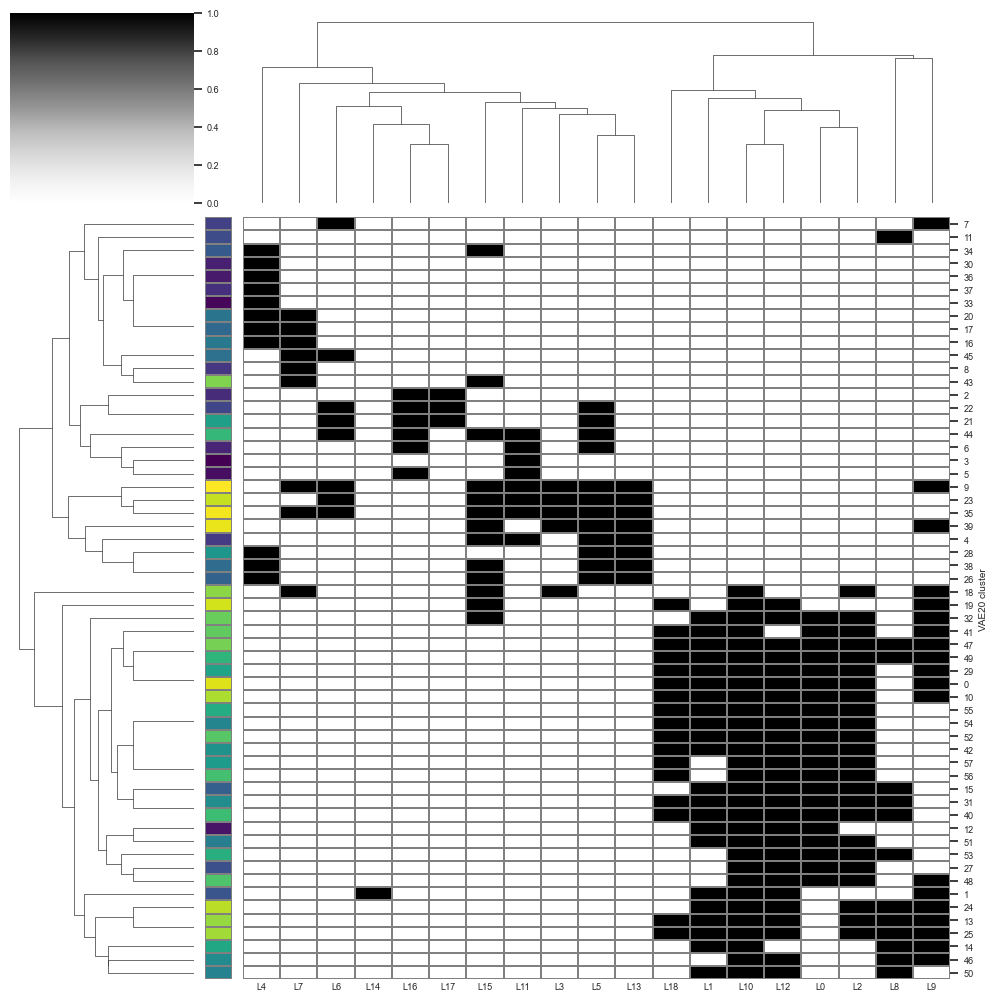

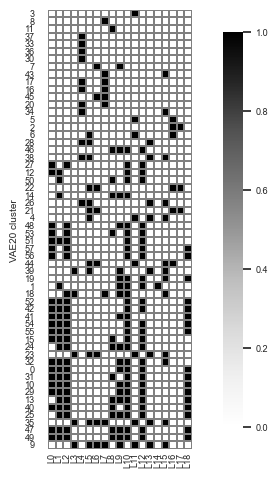

In [6]:
# Plot heatmap of CDF pvals
sns.set(font_scale=0.6)
sns.set_style('white')
heatmap = pvals[pvals <= 0.05]
heatmap = heatmap.notnull().astype('int')

test = heatmap.sum(axis=1)
test2 = df.groupby('VAE20').size()
test3 = test2.reindex(test.index)

test4 = pd.DataFrame(data={'Leiden_count': test, 'size': test3})
test4 = test4.sort_values(['Leiden_count', 'size'])
heatmap = heatmap.reindex(test4.index)

# Divide viridis colors into to the number of VAE clusters
viridis = plt.get_cmap('viridis', heatmap.shape[0])
# Map VAE clusters to their entropy scores
ent = dict(zip(heatmap.index, [entropies[i] for i in heatmap.index]))
# Sort the dict by entropy scores (i.e., values)
ent = {k: v for k, v in sorted(ent.items(), key=lambda item: item[1])}
# Map VAE clusters in heatmap, sorted by entropy, onto viridis colors
lut = dict(zip(ent.keys(), viridis.colors))
# Create colors index
row_colors = heatmap.index.map(lut)

g = sns.clustermap(
    heatmap, xticklabels=1, yticklabels=1, cmap='Greys', linecolor='grey',
    linewidths=0.3, cbar_kws={'shrink': 0.9}, row_colors=row_colors
)
g.ax_heatmap.set_ylabel('VAE20 cluster')
g.ax_heatmap.get_xaxis().set_tick_params(pad=-4)
plt.tight_layout()
plt.savefig(os.path.join(out, 'pvals_clustermap.pdf'))
plt.show()
plt.close('all')

sns.heatmap(
    heatmap, xticklabels=1, yticklabels=1, cmap='Greys', linecolor='grey',
    linewidths=0.3, square=True, cbar_kws={'shrink': 0.9}
)
plt.ylabel('VAE20 cluster')
plt.tick_params(axis='x', which='major', pad=-4)
plt.tight_layout()
plt.savefig(os.path.join(out, 'pvals_heatmap.pdf'))
plt.show()
plt.close('all')

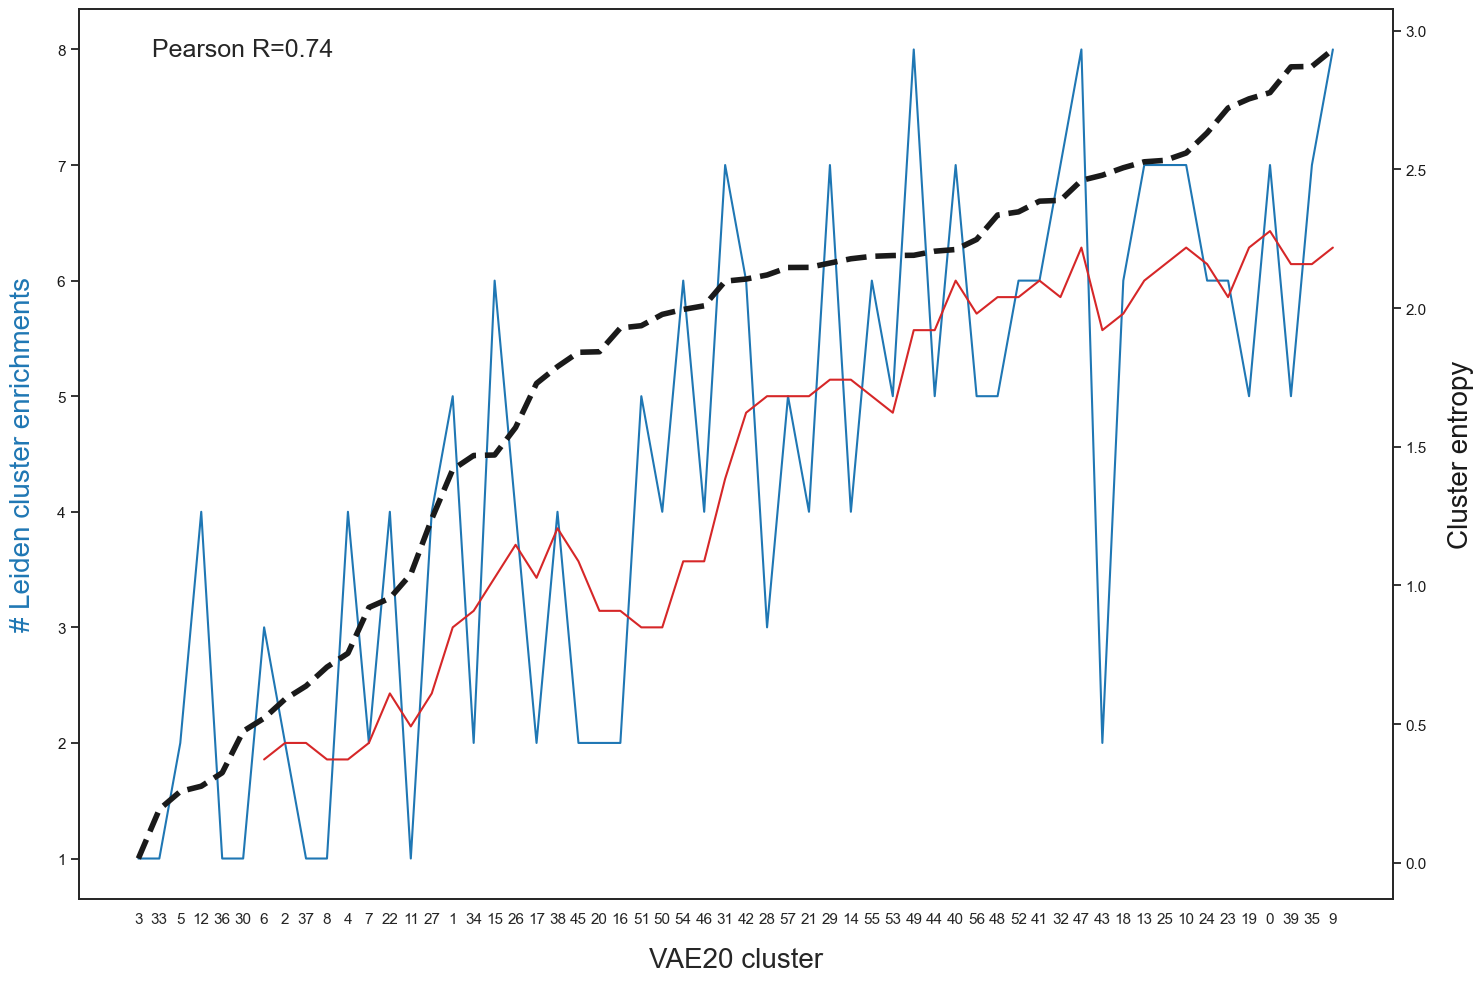

In [7]:
# Plot VAE20 cluster entropy and Leiden cluster enrichments on shared y-axis
sns.set(font_scale=1.0)
sns.set_style('white')
fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx()

count_thresholds = heatmap.sum(axis=1).sort_values()
count_thresholds = count_thresholds.reindex(entropies.keys())

e1['Leiden_count'] = count_thresholds

ax1.plot(
    [str(i) for i in count_thresholds.index], count_thresholds.values,
    c='tab:blue', lw=1.5, linestyle='-')

# Plot rolling count threshold average
rolling = count_thresholds.rolling(7).mean()
rolling.dropna(inplace=True)
ax1.plot([str(i) for i in rolling.index], rolling.values, c='tab:red', lw=1.5, linestyle='-')

ax1.set_xlabel('VAE20 cluster', size=20, labelpad=15)
ax1.set_ylabel('# Leiden cluster enrichments', size=20, labelpad=15, c='tab:blue')
ax1.tick_params(axis='y', colors='k')
ax2.plot([str(i) for i in entropies.keys()], entropies.values(), c='k', lw=4, linestyle='--')
ax2.set_ylabel('Cluster entropy', size=20, labelpad=15, c='k')
ax2.tick_params(axis='y', colors='k')

# Compute Pearson correlation coefficient
stat, pval = pearsonr(
    [i for i in entropies.values()], [i for i in count_thresholds.values], alternative='two-sided'
)
ax1.annotate(
    f'Pearson R={round(stat, 2)}', xy=(5, 8), horizontalalignment='center',
    verticalalignment='center', size=18
)
plt.tight_layout()
fig.savefig(os.path.join(out, 'entropy_vs_Leiden-enrichment.pdf'))
plt.show()
plt.close('all')

In [8]:
# Compute mean aggregate-channel intensities per VAE cluster
root = os.path.join(os.getcwd(), 'input/VAE20')
combo_dir = os.path.join(root, '6_latent_space_LD850/combined_zarr')

# Read percentile cutoffs selected in script 4_feature_preprocessing_selections
with open(
    os.path.join(root, '4_feature_preprocessing_selections/cutoffs.pkl'), 'rb'
    ) as handle:
    cutoffs = pickle.load(handle)

# Read combined training, validation, and test thumbnails, load into memory
X_combo = zarr.open(combo_dir)
X = transposeZarr(z=X_combo)  # X is now a dask array
X = X[df.index, :, :, :]

# Log-transform and clip outliers of image patch sample
X = clip_outlier_pixels(log_transform(X), cutoffs)

mean_signals = pd.DataFrame(columns=['mean', 'std', 'q25', 'q50', 'q75', 'VAE20'])

means = X.sum(axis=3).mean(axis=(1, 2)).compute()
stds = X.sum(axis=3).std(axis=(1, 2)).compute()

q25, q50, q75 = np.percentile(
    X.sum(axis=3).reshape(X.sum(axis=3).shape[0], -1).compute(), [25, 50, 75], axis=1
)

# Normalize pixels 0-1
# img = ((img - np.min(img)) / (np.max(img) - np.min(img)).astype('float32'))

mean_signals['VAE20'] = df['VAE20']
mean_signals['mean'] = means
mean_signals['std'] = stds
mean_signals['q25'] = q25
mean_signals['q50'] = q50
mean_signals['q75'] = q75

# Drop unclustered cells before plotting clustermap
mean_signals = mean_signals.groupby('VAE20').mean()

e1['mean'] = mean_signals['mean']
e1['std'] = mean_signals['std']
e1['q25'] = mean_signals['q25']
e1['q50'] = mean_signals['q50']
e1['q75'] = mean_signals['q75']

e1.to_csv(os.path.join(out, 'regression_variables.csv'))

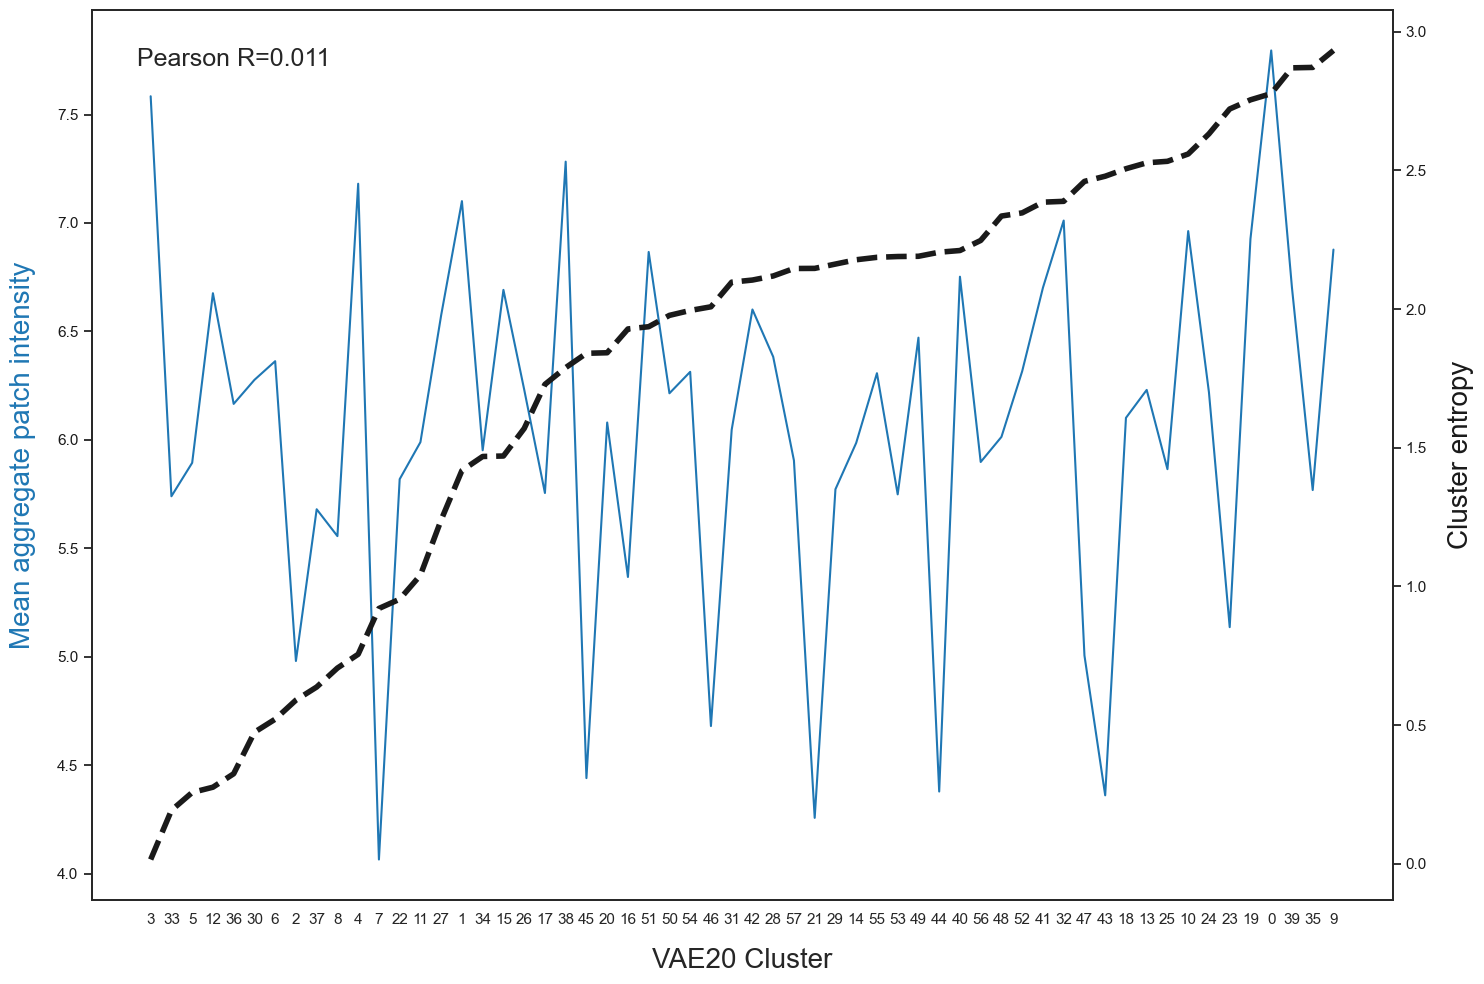

In [9]:
# Plot VAE cluster entropy and mean aggregate patch intensity on shared y-axis
mean_signals = mean_signals.reindex(entropies.keys())

sns.set(font_scale=1.0)
sns.set_style('white')
fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx()
ax1.plot(
    [str(i) for i in mean_signals.index], mean_signals['mean'],
    c='tab:blue', lw=1.5, linestyle='-')
ax1.set_xlabel('VAE20 Cluster', size=20, labelpad=15)
ax1.set_ylabel('Mean aggregate patch intensity', size=20, labelpad=15, c='tab:blue')
ax1.tick_params(axis='y', colors='k')
ax2.plot([str(i) for i in entropies.keys()], entropies.values(), c='k', lw=4, linestyle='--')
ax2.set_ylabel('Cluster entropy', size=20, labelpad=15, c='k')
ax2.tick_params(axis='y', colors='k')

# Compute Pearson correlation coefficient
stat, pval = pearsonr(
    [i for i in entropies.values()], [i for i in mean_signals['mean'].values],
    alternative='two-sided'
)
ax2.annotate(
    f'Pearson R={round(stat, 3)}', xy=(4.0, 2.9),
    horizontalalignment='center', verticalalignment='center', size=18
)
plt.tight_layout()
fig.savefig(os.path.join(out, 'entropy_vs_mean-agg-signals.pdf'))
plt.show()
plt.close('all')

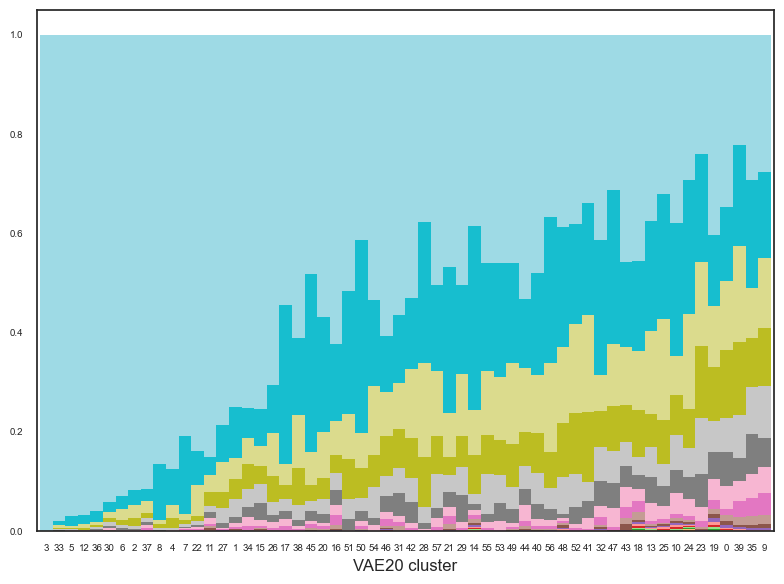

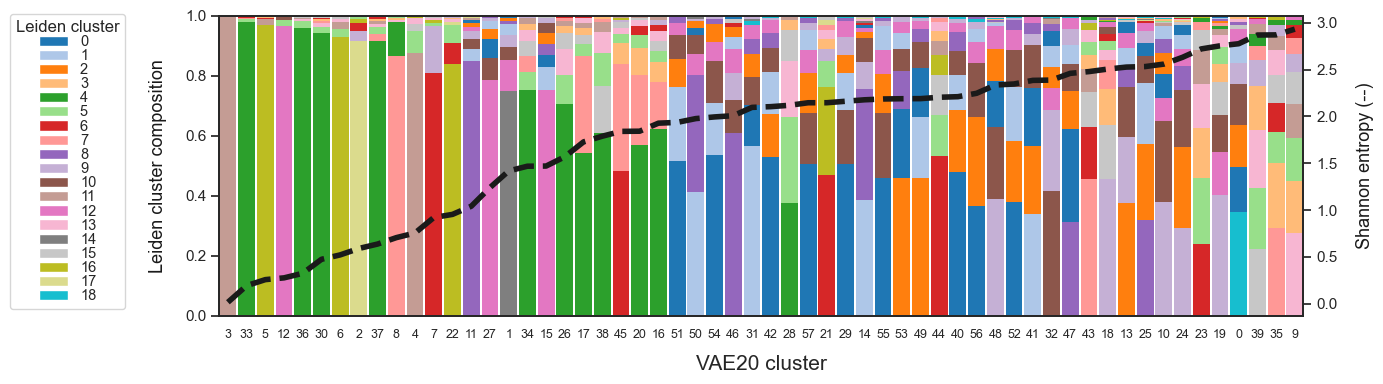

In [10]:
# Plot stacked barcharts
bar = df.groupby(['VAE20', 'Leiden']).size().unstack().fillna(0)

# Normalize Leiden counts per VAE cluster (0-1), sort VAE20 clusters by entropy
bar = bar.div(bar.sum(axis=1), axis=0)
bar = bar.reindex(entropies.keys())

vals = bar.values.copy()
vals.sort(axis=1)
pbar = pd.DataFrame(index=bar.index, columns=bar.columns, data=vals)
ax = pbar.plot.bar(
    stacked=True, lw=0.0, legend=False, width=1.0, colormap='tab20',
    rot=0, figsize=(8,6), fontsize=7
)
ax.set_xlabel('VAE20 cluster')
plt.tight_layout()
plt.savefig(os.path.join(out, 'stacked_bar.pdf'))
plt.show()
plt.close('all')

fig, ax1 = plt.subplots(figsize=(14, 4))
ax2 = ax1.twinx()
x = bar.index.astype('str')
indexes = np.argsort(bar.values).T
heights = np.sort(bar.values).T
order = -1
bottoms = heights[::order].cumsum(axis=0)
bottoms = np.insert(bottoms, 0, np.zeros(len(bottoms[0])), axis=0)
cmap = plt.get_cmap('tab20')
cmap = [i for i in cmap.colors]
mpp_colors = dict(zip(bar.columns, cmap))
for btms, (idxs, vals) in enumerate(list(zip(indexes, heights))[::order]):
    mps = np.take(np.array(bar.columns), idxs)
    ax1.bar(
        x, height=vals, width=0.9, lw=0.0, bottom=bottoms[btms],
        color=[mpp_colors[m] for m in mps]
    )
ax1.set_xlabel('VAE20 cluster', size=15, labelpad=10)
ax1.set_ylabel('Leiden cluster composition', size=13, labelpad=13, c='k')
ax1.tick_params(axis='x', which='major', labelsize=9)
ax1.margins(x=0)
markers = [Patch(facecolor=color, edgecolor=None) for color in mpp_colors.values()]
plt.legend(
    markers, mpp_colors.keys(), title='Leiden cluster', prop={'size': 10.5},
    labelspacing=0.01, bbox_to_anchor=[-0.2, 1.03], loc='upper left'
)

ax2.plot([str(i) for i in entropies.keys()], entropies.values(), c='k', lw=4, linestyle='--')
ax2.set_ylabel('Shannon entropy (--)', size=13, labelpad=13, c='k')

plt.tight_layout()
plt.savefig(os.path.join(out, 'stacked_bar_new.pdf'))
plt.show()
plt.close('all')